In [62]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 총발전, 총소비 데이터 추출

In [2]:
df1 = pd.read_csv('./211112/211112 dashboard_time_series_chart.csv', parse_dates = True)

In [4]:
df1['DateTime']= pd.to_datetime(df1['DateTime'])

In [5]:
df1=df1[(df1['DateTime']>='2021-09-13 00:00:00')]

In [6]:
df1=df1[(df1['DateTime']<'2021-11-04 00:00:00')]

In [8]:
df1=df1.set_index('DateTime')

In [9]:
df1=df1.resample('1T').mean()

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74880 entries, 2021-09-13 00:00:00 to 2021-11-03 23:59:00
Freq: T
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   energyTotalProduce          54408 non-null  float64
 1   energyTotalConsume          54408 non-null  float64
 2   ToESS(We)                   54408 non-null  float64
 3   ESSout(We)                  54408 non-null  float64
 4   energyTotalSelfConsumeRate  54408 non-null  float64
 5   energyTotalSelfRate         54408 non-null  float64
 6   SCF                         54408 non-null  float64
 7   LCF                         54408 non-null  float64
 8   SCF_acc                     54408 non-null  float64
 9   LCF_acc                     54408 non-null  float64
dtypes: float64(10)
memory usage: 6.3 MB


In [11]:
df1=df1.fillna(0)

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74880 entries, 2021-09-13 00:00:00 to 2021-11-03 23:59:00
Freq: T
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   energyTotalProduce          74880 non-null  float64
 1   energyTotalConsume          74880 non-null  float64
 2   ToESS(We)                   74880 non-null  float64
 3   ESSout(We)                  74880 non-null  float64
 4   energyTotalSelfConsumeRate  74880 non-null  float64
 5   energyTotalSelfRate         74880 non-null  float64
 6   SCF                         74880 non-null  float64
 7   LCF                         74880 non-null  float64
 8   SCF_acc                     74880 non-null  float64
 9   LCF_acc                     74880 non-null  float64
dtypes: float64(10)
memory usage: 6.3 MB


# ESS충방전량 추출

In [14]:
df2 = pd.read_csv('./211104/211104 kepsh1.csv', parse_dates = True)

In [15]:
df2['DateTime']= pd.to_datetime(df2['DateTime'])

In [16]:
df2=df2[(df2['DateTime']>='2021-09-13 00:00:00')]

In [17]:
df2=df2[(df2['DateTime']<'2021-11-04 00:00:00')]

In [19]:
df2=df2.set_index('DateTime')

In [20]:
df2=df2.resample('1T').mean()

In [21]:
df2=df2.fillna(0)

In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74880 entries, 2021-09-13 00:00:00 to 2021-11-03 23:59:00
Freq: T
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Room_Temp(�C)                 74880 non-null  float64
 1   T1(�C)                        74880 non-null  float64
 2   T2(�C)                        74880 non-null  float64
 3   T3(�C)                        74880 non-null  float64
 4   T4(�C)                        74880 non-null  float64
 5   T5(�C)                        74880 non-null  float64
 6   T6(�C)                        74880 non-null  float64
 7   T8(�C)                        74880 non-null  float64
 8   T9(�C)                        74880 non-null  float64
 9   T10(�C)                       74880 non-null  float64
 10  T12(�C)                       74880 non-null  float64
 11  F1(lpm)                       74880 non-null  float64
 12  F2(lpm)          

# ToGrid 데이터 추출

In [23]:
df3 = pd.read_csv('./211112/211112 dashboard_facility_enegy_flow.csv', parse_dates = True)

In [24]:
df3['DateTime']= pd.to_datetime(df3['DateTime'])

In [25]:
df3=df3[(df3['DateTime']>='2021-09-13 00:00:00')]

In [26]:
df3=df3[(df3['DateTime']<'2021-11-04 00:00:00')]

In [27]:
df3=df3.set_index('DateTime')

In [28]:
df3=df3.resample('1T').mean()

In [29]:
df3=df3.fillna(0)

In [30]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74880 entries, 2021-09-13 00:00:00 to 2021-11-03 23:59:00
Freq: T
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PVout(We)         74880 non-null  float64
 1   PVTout(We)        74880 non-null  float64
 2   FCout(We)         74880 non-null  float64
 3   PlugLoad(We)      74880 non-null  float64
 4   LightLoad(We)     74880 non-null  float64
 5   FromGrid(We)      74880 non-null  float64
 6   ToGrid(We)        74880 non-null  float64
 7   ToESS(We)         74880 non-null  float64
 8   ESSout(We)        74880 non-null  float64
 9   ESS2Grid(We)      74880 non-null  float64
 10  ESS2ASHP(We)      74880 non-null  float64
 11  ESS2GSHP(We)      74880 non-null  float64
 12  Grid2ASHP(We)     74880 non-null  float64
 13  Grid2GSHP(We)     74880 non-null  float64
 14  PVTHout(Wt)       74880 non-null  float64
 15  FCHout(Wt)        74880 non-null  float64
 1

# KPEC 합치기

In [43]:
df_kpec = pd.DataFrame()
df_kpec = pd.DataFrame(pd.date_range('2021-09-13 00:00:00', '2021-11-03 23:59:00', freq='T'), columns=['Time'])

In [44]:
df_kpec

,Time
0,2021-09-13 00:00:00
1,2021-09-13 00:01:00
2,2021-09-13 00:02:00
3,2021-09-13 00:03:00
4,2021-09-13 00:04:00
...,...
74875,2021-11-03 23:55:00
74876,2021-11-03 23:56:00
74877,2021-11-03 23:57:00
74878,2021-11-03 23:58:00


In [45]:
df_kpec = df_kpec.set_index('Time')

In [46]:
df_kpec['Cons_kpec(W)'] = df1['energyTotalConsume']
df_kpec['Prod_kpec(W)'] = df1['energyTotalProduce']
df_kpec['ESS_kpec(W)'] = df2['ESS_Power(W)']*(-1)

In [47]:
df_kpec = df_kpec[df_kpec['Cons_kpec(W)']< 40000]

In [48]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74876 entries, 2021-09-13 00:00:00 to 2021-11-03 23:59:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cons_kpec(W)  74876 non-null  float64
 1   Prod_kpec(W)  74876 non-null  float64
 2   ESS_kpec(W)   74876 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB


In [49]:
df_kpec['PV_kpec(We)'] = df3['PVout(We)']
df_kpec['PVT_kpec(We)'] = df3['PVTout(We)']
df_kpec['FC_kpec(We)'] = df3['FCout(We)']
df_kpec['PlugLoad(We)'] = df3['PlugLoad(We)']
df_kpec['LightLoad(We)'] = df3['LightLoad(We)']
df_kpec['FromGrid(We)'] = df3['FromGrid(We)']
df_kpec['ToGrid(We)'] = df3['ToGrid(We)']
df_kpec['ToESS(We)'] = df3['ToESS(We)']
df_kpec['ESSout(We)'] = df3['ESSout(We)']
df_kpec['ESS2Grid(We)'] = df3['ESS2Grid(We)']
df_kpec['ESS2ASHP(We)'] = df3['ESS2ASHP(We)']
df_kpec['ESS2GSHP(We)'] = df3['ESS2GSHP(We)']
df_kpec['Grid2ASHP(We)'] = df3['Grid2ASHP(We)']
df_kpec['Grid2GSHP(We)'] = df3['Grid2GSHP(We)']
df_kpec['PVTHout(Wt)'] = df3['PVTHout(Wt)']
df_kpec['FCHout(Wt)'] = df3['FCHout(Wt)']
df_kpec['ASHP2HTES(Wt)'] = df3['ASHP2HTES(Wt)']
df_kpec['GSHP2CTES(Wt)'] = df3['GSHP2CTES(Wt)']
df_kpec['GSHP2HTES(Wt)'] = df3['GSHP2HTES(Wt)']
df_kpec['ASHP2Cool(Wt)'] = df3['ASHP2Cool(Wt)']
df_kpec['ASHP2Heat(Wt)'] = df3['ASHP2Heat(Wt)']
df_kpec['CTES2Cool(Wt)'] = df3['CTES2Cool(Wt)']
df_kpec['HTES2Heat(Wt)'] = df3['HTES2Heat(Wt)']
df_kpec['HTES2Water(Wt)'] = df3['HTES2Water(Wt)']
df_kpec['DirectElec(We)'] = df3['DirectElec(We)']
df_kpec['CoolLoad(Wt)'] = df3['CoolLoad(Wt)']
df_kpec['HeatLoad(Wt)'] = df3['HeatLoad(Wt)']
df_kpec['HotwaterLoad(Wt)'] = df3['HotwaterLoad(Wt)']

In [50]:
df_kpec['PV_kpec(We)'] = np.where(df_kpec['PV_kpec(We)']<0, 0, df_kpec['PV_kpec(We)'])
df_kpec['PVT_kpec(We)'] = np.where(df_kpec['PVT_kpec(We)']<0, 0, df_kpec['PVT_kpec(We)'])
df_kpec['FC_kpec(We)'] = np.where(df_kpec['FC_kpec(We)']<0, 0, df_kpec['FC_kpec(We)'])
df_kpec['PlugLoad(We)'] = np.where(df_kpec['PlugLoad(We)']<0, 0, df_kpec['PlugLoad(We)'])

In [52]:
df_kpec['Cons_acc_kpec(Wh)'] = df_kpec['Cons_kpec(W)'].cumsum()*60*1/3600
df_kpec['Prod_acc_kpec(Wh)'] = df_kpec['Prod_kpec(W)'].cumsum()*60*1/3600
df_kpec['ESS_acc_kpec(Wh)'] = df_kpec['ESS_kpec(W)'].cumsum()*60*1/3600

df_kpec['PV_acc_kpec(Wh)'] = df_kpec['PV_kpec(We)'].cumsum()*60*1/3600
df_kpec['PVT_acc_kpec(Wh)'] = df_kpec['PVT_kpec(We)'].cumsum()*60*1/3600
df_kpec['FC_acc_kpec(Wh)'] = df_kpec['FC_kpec(We)'].cumsum()*60*1/3600
df_kpec['PlugLoad_acc(Wh)'] = df_kpec['PlugLoad(We)'].cumsum()*60*1/3600
df_kpec['LightLoad_acc(Wh)'] = df_kpec['LightLoad(We)'].cumsum()*60*1/3600
df_kpec['FromgGrid_acc(Wh)'] = df_kpec['FromGrid(We)'].cumsum()*60*1/3600
df_kpec['ToGrid_acc(Wh)'] = df_kpec['ToGrid(We)'].cumsum()*60*1/3600
df_kpec['ToESS_acc(Wh)'] = df_kpec['ToESS(We)'].cumsum()*60*1/3600
df_kpec['ESSout_acc(Wh)'] = df_kpec['ESSout(We)'].cumsum()*60*1/3600
df_kpec['ESS2Grid_acc(Wh)'] = df_kpec['ESS2Grid(We)'].cumsum()*60*1/3600
df_kpec['ESS2ASHP_acc(Wh)'] = df_kpec['ESS2ASHP(We)'].cumsum()*60*1/3600
df_kpec['ESS2GSHP_acc(Wh)'] = df_kpec['ESS2GSHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2ASHP_acc(Wh)'] = df_kpec['Grid2ASHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2GSHP_acc(Wh)'] = df_kpec['Grid2GSHP(We)'].cumsum()*60*1/3600
df_kpec['PVTHout_acc(Wh)'] = df_kpec['PVTHout(Wt)'].cumsum()*60*1/3600
df_kpec['FCHout_acc(Wh)'] = df_kpec['FCHout(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2HTES_acc(Wh)'] = df_kpec['ASHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2CTES_acc(Wh)'] = df_kpec['GSHP2CTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2HTES_acc(Wh)'] = df_kpec['GSHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Cool_acc(Wh)'] = df_kpec['ASHP2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Heat_acc(Wh)'] = df_kpec['ASHP2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['CTES2Cool_acc(Wh)'] = df_kpec['CTES2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Heat_acc(Wh)'] = df_kpec['HTES2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Water_acc(Wh)'] = df_kpec['HTES2Water(Wt)'].cumsum()*60*1/3600
df_kpec['DirectElec_acc(Wh)'] = df_kpec['DirectElec(We)'].cumsum()*60*1/3600
df_kpec['CoolLoad_acc(Wh)'] = df_kpec['CoolLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HeatLoad_acc(Wh)'] = df_kpec['HeatLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HotwaterLoad_acc(Wh)'] = df_kpec['HotwaterLoad(Wt)'].cumsum()*60*1/3600

In [53]:
df_kpec['E_self(W)'] = df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'] - df_kpec['ToGrid(We)']
df_kpec['E_self_acc(Wh)'] =df_kpec['E_self(W)'].cumsum()*60*1/3600

In [54]:
df_kpec['denominator'] = df_kpec.loc[:,['E_self(W)','Cons_kpec(W)']].min(axis=1)
df_kpec['denominator_acc'] = df_kpec.loc[:,['E_self_acc(Wh)','Cons_acc_kpec(Wh)']].min(axis=1)

In [55]:
df_kpec['SCF'] = df_kpec['denominator']/(df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'])
df_kpec['LCF'] = df_kpec['denominator']/df_kpec['Cons_kpec(W)']

In [56]:
df_kpec['SCF_acc'] = df_kpec['denominator_acc']/(df_kpec['Prod_acc_kpec(Wh)'] - df_kpec['ESS_acc_kpec(Wh)'])
df_kpec['LCF_acc'] = df_kpec['denominator_acc']/df_kpec['Cons_acc_kpec(Wh)']

In [57]:
df_kpec['self_sustain'] = df_kpec['Prod_acc_kpec(Wh)']/df_kpec['Cons_acc_kpec(Wh)']
df_kpec['Avg_SCF&LCF']=(df_kpec['SCF_acc']+df_kpec['LCF_acc'])/2

In [58]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74876 entries, 2021-09-13 00:00:00 to 2021-11-03 23:59:00
Data columns (total 72 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cons_kpec(W)          74876 non-null  float64
 1   Prod_kpec(W)          74876 non-null  float64
 2   ESS_kpec(W)           74876 non-null  float64
 3   PV_kpec(We)           74876 non-null  float64
 4   PVT_kpec(We)          74876 non-null  float64
 5   FC_kpec(We)           74876 non-null  float64
 6   PlugLoad(We)          74876 non-null  float64
 7   LightLoad(We)         74876 non-null  float64
 8   FromGrid(We)          74876 non-null  float64
 9   ToGrid(We)            74876 non-null  float64
 10  ToESS(We)             74876 non-null  float64
 11  ESSout(We)            74876 non-null  float64
 12  ESS2Grid(We)          74876 non-null  float64
 13  ESS2ASHP(We)          74876 non-null  float64
 14  ESS2GSHP(We)          74876 non-nul

In [59]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),PV_kpec(We),PVT_kpec(We),FC_kpec(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),...,E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,,,,,
2021-09-13 00:00:00,6696.0,10.0,-0.0,0.0,10.0,0.0,4986.0,1448.0,6686.0,0.0,...,10.0,1.666667e-01,10.0,1.666667e-01,1.0,0.001493,1.000000,0.001493,0.001493,0.500747
2021-09-13 00:01:00,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.666667e-01,0.0,1.666667e-01,NaN,NaN,1.000000,0.001493,0.001493,0.500747
2021-09-13 00:02:00,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.666667e-01,0.0,1.666667e-01,NaN,NaN,1.000000,0.001493,0.001493,0.500747
2021-09-13 00:03:00,6173.0,10.0,-0.0,0.0,10.0,0.0,4882.0,1034.0,6163.0,0.0,...,10.0,3.333333e-01,10.0,3.333333e-01,1.0,0.001620,1.000000,0.001554,0.001554,0.500777
2021-09-13 00:04:00,6544.0,10.0,-0.0,0.0,10.0,0.0,5062.0,1225.0,6534.0,0.0,...,10.0,5.000000e-01,10.0,5.000000e-01,1.0,0.001528,1.000000,0.001545,0.001545,0.500773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,7572.0,569.0,-0.0,0.0,0.0,569.0,6000.0,1340.0,7003.0,0.0,...,569.0,4.577551e+06,569.0,4.577551e+06,1.0,0.075145,0.450660,0.485337,1.078353,0.467999
2021-11-03 23:56:00,7720.0,568.0,-0.0,0.0,0.0,568.0,6016.0,1471.0,7152.0,0.0,...,568.0,4.577560e+06,568.0,4.577560e+06,1.0,0.073575,0.450661,0.485331,1.078339,0.467996
2021-11-03 23:57:00,7963.0,568.0,-0.0,0.0,0.0,568.0,5964.0,1765.0,7395.0,0.0,...,568.0,4.577570e+06,568.0,4.577570e+06,1.0,0.071330,0.450661,0.485325,1.078325,0.467993


In [60]:
df_kpec.to_csv('./211112_kpec_tot_ver6.csv')

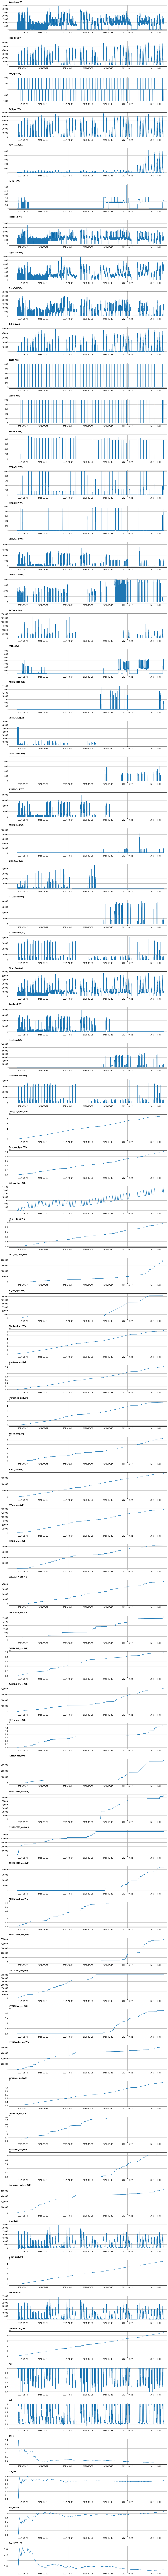

In [63]:
fig, ax = plt.subplots(figsize=(18,300))

for i in range(len(df_kpec.columns)):
    plt.subplot(len(df_kpec.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpec.columns[i]
    plt.plot(df_kpec[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [64]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),PV_kpec(We),PVT_kpec(We),FC_kpec(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),...,E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,,,,,
2021-09-13 00:00:00,6696.0,10.0,-0.0,0.0,10.0,0.0,4986.0,1448.0,6686.0,0.0,...,10.0,1.666667e-01,10.0,1.666667e-01,1.0,0.001493,1.000000,0.001493,0.001493,0.500747
2021-09-13 00:01:00,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.666667e-01,0.0,1.666667e-01,NaN,NaN,1.000000,0.001493,0.001493,0.500747
2021-09-13 00:02:00,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.666667e-01,0.0,1.666667e-01,NaN,NaN,1.000000,0.001493,0.001493,0.500747
2021-09-13 00:03:00,6173.0,10.0,-0.0,0.0,10.0,0.0,4882.0,1034.0,6163.0,0.0,...,10.0,3.333333e-01,10.0,3.333333e-01,1.0,0.001620,1.000000,0.001554,0.001554,0.500777
2021-09-13 00:04:00,6544.0,10.0,-0.0,0.0,10.0,0.0,5062.0,1225.0,6534.0,0.0,...,10.0,5.000000e-01,10.0,5.000000e-01,1.0,0.001528,1.000000,0.001545,0.001545,0.500773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,7572.0,569.0,-0.0,0.0,0.0,569.0,6000.0,1340.0,7003.0,0.0,...,569.0,4.577551e+06,569.0,4.577551e+06,1.0,0.075145,0.450660,0.485337,1.078353,0.467999
2021-11-03 23:56:00,7720.0,568.0,-0.0,0.0,0.0,568.0,6016.0,1471.0,7152.0,0.0,...,568.0,4.577560e+06,568.0,4.577560e+06,1.0,0.073575,0.450661,0.485331,1.078339,0.467996
2021-11-03 23:57:00,7963.0,568.0,-0.0,0.0,0.0,568.0,5964.0,1765.0,7395.0,0.0,...,568.0,4.577570e+06,568.0,4.577570e+06,1.0,0.071330,0.450661,0.485325,1.078325,0.467993


In [ ]:
df = pd.read_csv('./211112_kpec_tot_ver6.csv', parse_dates = True)

In [ ]:
df

In [ ]:
df['Time']= pd.to_datetime(df['Time'])

In [ ]:
fig, ax = plt.subplots(figsize=(18,70))


for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    name = df.columns[i]
    plt.scatter(x=df['Time'], y=df[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()